# Problem Set 4 - Structural Estimation

## John Wilson
### July 15, 2017

In [1]:
import numpy as np
import scipy.stats as sts
from scipy.special import gamma, beta
from matplotlib import pyplot as plt
import scipy.optimize as opt
import scipy.integrate as integrate
import numpy.linalg as lin
%matplotlib inline

## Problem 3

In [2]:
data = np.loadtxt("data/usincmoms.txt")
midpoints = data[:,1]/1000

### Part a)

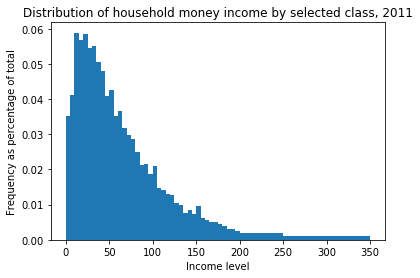

In [3]:
bins = data[:-2,1]/1000 - 2.5
bins=np.append(bins,np.array([200,250,350]))
weights = np.copy(data[:,0])
weights_adj = np.copy(weights)
weights_adj[-2] /= 10
weights_adj[-1] /= 20
vals, bins, fig = plt.hist(data[:,1]/1000,bins = bins, weights = weights_adj)
plt.title("Distribution of household money income by selected class, 2011")
plt.xlabel("Income level")
plt.ylabel("Frequency as percentage of total")
plt.show()

### Part b)

In [4]:
# Divide the bins into two lists - left limits and right limits - to
# facilitate moment calculations
left = bins[:-1]
right = bins[1:]
n = len(data)

def get_model_moments(mu, sigma):
    fx = lambda x: sts.lognorm.cdf(x, sigma, scale = np.exp(mu))
    moments = np.empty(n)
    for i in range(n):
        if i == n-1:
            moments[i] = fx(np.inf) - fx(left[-1])
        else:
            moments[i] = fx(right[i]) - fx(left[i])
    return moments

def error_vec(xvals, mu, sigma):
    m_moments = get_model_moments(mu, sigma)
    return m_moments - xvals

def criterion(params, weights):
    mu, sigma = params
    W = np.diag(weights)
    err = error_vec(weights, mu, sigma)
    crit_val = np.dot(np.dot(err, W), err)
    return crit_val

In [5]:
# Initialize values for mu and sigma starting guesses
mu_init = np.log(np.sum(midpoints * weights))
sigma_init = 5
init_vec = np.array([mu_init, sigma_init])
results = opt.minimize(criterion, init_vec, \
                       args = weights, method = 'L-BFGS-B',\
                       bounds=((1e-10, None), (1e-10, None)))

mu_GMM= 3.90970829092  sigma_GMM= 0.954698944826
Criterion value:  5.42286946083e-05


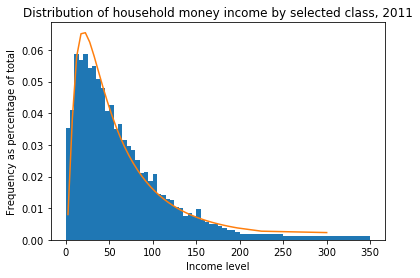

In [6]:
mu_GMM, sigma_GMM = results.x
crit_ln = results.fun
print("mu_GMM=",mu_GMM, " sigma_GMM=",sigma_GMM)
print("Criterion value: ",crit_ln)
fxln = lambda x: sts.lognorm.cdf(x, sigma_GMM, scale = np.exp(mu_GMM))
moments_ln = np.empty(n)
for i in range(n):
    if i == n-1:
        moments_ln[i] = fxln(np.inf) - fxln(left[-1])
    else:
        moments_ln[i] = fxln(right[i]) - fxln(left[i])
moments_ln[-1] /= 20
moments_ln[-2] /= 10
vals, bins, fig = plt.hist(data[:,1]/1000,bins = bins, weights = weights_adj)
plt.plot(midpoints,moments_ln)
plt.title("Distribution of household money income by selected class, 2011")
plt.xlabel("Income level")
plt.ylabel("Frequency as percentage of total")
plt.show()

### Part c)

In [7]:
def gamma_pdf(xvals, alpha, beta):
    G = gamma(alpha)
    return xvals ** (alpha - 1) * np.exp(-xvals / beta) / (G * beta ** alpha)

def get_model_moments_GA(alpha, beta):
    fx = lambda x: sts.gamma.cdf(x, alpha, scale=beta)
    moments = np.empty(n)
    for i in range(n):
        if i == n-1:
            moments[i] = fx(np.inf) - fx(left[-1])
        else:
            moments[i] = fx(right[i]) - fx(left[i])
    return moments

def error_vec_GA(xvals, alpha, beta):
    m_moments = get_model_moments_GA(alpha, beta)
    return m_moments - xvals

def criterion_GA(params, *args):
    alpha, beta = params
    weights, W = args
    err = error_vec_GA(weights, alpha, beta)
    err = err.reshape((42,1))
    crit_val = np.dot(np.dot(err.T, W), err)
    return crit_val

In [8]:
alpha_init = 3
beta_init = 20
W = np.diag(weights)
init_vec = np.array([alpha_init, beta_init])
results = opt.minimize(criterion_GA, init_vec, \
                       args = (weights, W), method = 'L-BFGS-B',\
                       bounds=((None, None), (1e-10, None)))

alpha_GMM= 1.50411195985  beta_GMM= 41.181090293
Criterion value:  [[  1.43637196e-05]]


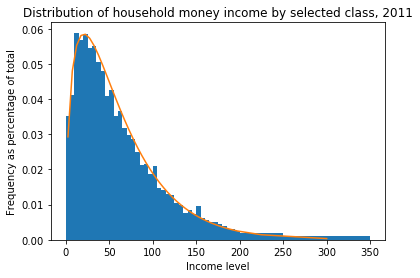

In [9]:
alpha_GMM, beta_GMM = results.x
crit_gamma = results.fun
print("alpha_GMM=",alpha_GMM, " beta_GMM=",beta_GMM)
print("Criterion value: ", crit_gamma)
fx = lambda x: sts.gamma.cdf(x, alpha_GMM, scale=beta_GMM)
moments_gamma = np.empty(len(bins)-1)
for i in range(n):
    if i == n-1:
        moments_gamma[i] = fx(np.inf) - fx(left[-1])
    else:
        moments_gamma[i] = fx(right[i]) - fx(left[i])
moments_gamma[-1] /= 20
moments_gamma[-2] /= 10
vals, bins, fig = plt.hist(data[:,1]/1000,bins = bins, weights = weights_adj)
plt.plot(midpoints,moments_gamma)
plt.title("Distribution of household money income by selected class, 2011")
plt.xlabel("Income level")
plt.ylabel("Frequency as percentage of total")
plt.show()

### Part d)

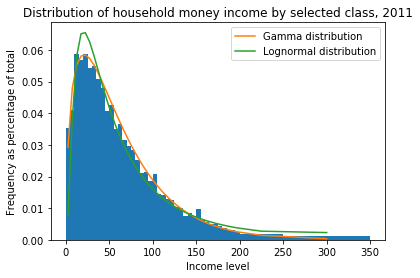

In [10]:
vals, bins, fig = plt.hist(data[:,1]/1000,bins = bins, weights = weights_adj)
plt.plot(midpoints,moments_gamma, label='Gamma distribution')
plt.plot(midpoints,moments_ln, label = 'Lognormal distribution')
plt.legend(loc = 'upper right')
plt.title("Distribution of household money income by selected class, 2011")
plt.xlabel("Income level")
plt.ylabel("Frequency as percentage of total")
plt.show()

Since both distributions are using the same weighting matrix under this model, a precise way to tell which is the best fit is to simply check the value of the criterion function, which is $e^TWe$. The distribution with the lowest criterion value is the best fitting distribution.

In [11]:
print("The criterion value for lognormal distribution is: ", crit_ln)
print("The criterion value for gamma distribution is: ", crit_gamma)

The criterion value for lognormal distribution is:  5.42286946083e-05
The criterion value for gamma distribution is:  [[  1.43637196e-05]]


The gamma distribution is a better fit according to the measurements employed by GMM.

### Part e)

In [12]:
err = error_vec_GA(weights, alpha_GMM, beta_GMM)
err = err.reshape((42,1))
VCV2 = np.dot(err, err.T) / weights.shape[0]
# Use the pseudo-inverse calculated by SVD because VCV2 is ill-conditioned
W_hat2 = lin.pinv(VCV2)

In [13]:
alpha_init = alpha_GMM
beta_init = beta_GMM
init_vec = np.array([alpha_init, beta_init])
results_2 = opt.minimize(criterion_GA, init_vec, \
                       args = (weights, W_hat2), method = 'L-BFGS-B',\
                       bounds=((None, None), (1e-15, None)))

alpha_GMM2= 2.2298403687  beta_GMM2= 41.387536019
Criterion value is:  [[  1.43637196e-05]]


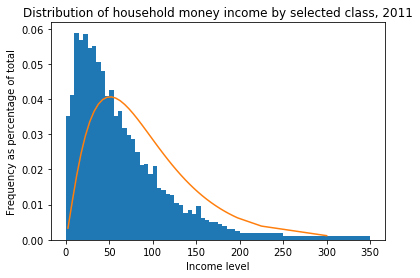

In [14]:
alpha_GMM2, beta_GMM2 = results_2.x
crit_gamma2 = results.fun
print("alpha_GMM2=",alpha_GMM2, " beta_GMM2=",beta_GMM2)
print("Criterion value is: ", crit_gamma2)
fx2 = lambda x: sts.gamma.cdf(x, alpha_GMM2, scale=beta_GMM2)
moments_gamma2 = np.empty(len(bins)-1)
for i in range(n):
    if i == n-1:
        moments_gamma2[i] = fx2(np.inf) - fx2(left[-1])
    else:
        moments_gamma2[i] = fx2(right[i]) - fx2(left[i])
moments_gamma2[-1] /= 20
moments_gamma2[-2] /= 10
vals, bins, fig = plt.hist(data[:,1]/1000,bins = bins, weights = weights_adj)
plt.plot(midpoints,moments_gamma2)
plt.title("Distribution of household money income by selected class, 2011")
plt.xlabel("Income level")
plt.ylabel("Frequency as percentage of total")
plt.show()

The value for alpha changed a bit, but the value for beta stayed about the same is it was. To compare it is probably best done graphically. You can't compare the value of the criterion functions directly because different weighting matrices are used.